# Probit Regression

We aim to learn a linear classifier \\(\mathbf{x} \mapsto \operatorname{sign} (\mathbf{w}^\top \mathbf{x})\\), where \\(\mathbf{w} \in \mathbb{R}^d\\) is the weight vector.
We impose a Gaussian prior \\(\mathbf{w} \sim \mathcal{N}(0, \mathbf{I})\\), and assume the label \\(y\\) is generated by a Bernoulli distribution:
\\[
\Pr(y = +1 \mid \mathbf{w}) = \Phi(\mathbf{w}^\top \mathbf{x}), \quad \Pr(y = -1 \mid \mathbf{w}) = 1 - \Phi(\mathbf{w}^\top \mathbf{x}),
\\]
where \\(\Phi\\) is the CDF of the standard normal distribution.
Given a dataset \\(\mathbf{X} \in \mathbb{R}^{n \times d}\\) and its labels \\(\mathbf{y} \in \{-1, +1\}^n\\), learning the weight vector requires computing the posterior distribution \\(p(\mathbf{w} \mid \mathbf{y})\\).

We will carry out the posterior inference by elliptical slice sampling.
This is based on the following key observation (more details in the [Wikpedia page](https://en.wikipedia.org/wiki/Probit_model#Conceptual_framework)):
1. Observing a positive label \\(y = +1\\) is equivalent to observing \\(\mathbf{x}^\top \mathbf{w} + u \geq 0\\), where \\(u \sim \mathcal{N}(0, 1)\\) is an independent standard normal variable;
1. Observing a negative label \\(y = -1\\) is equivalent to observing \\(\mathbf{x}^\top \mathbf{w} + u \leq 0\\).

To compute the posterior \\(p(\mathbf{w} \mid \mathbf{y})\\), all we need is to condition \\(\mathbf{w}\\) on the linear inequality constraints \\(\mathbf{y} \odot (\mathbf{X} \mathbf{w}) + \mathbf{u} \geq 0\\), where \\(\mathbf{u}\\) is a \\(n\\)-dimensional standard normal random variable.
Thus, posterior samples can be obtained by sampling from the joint distribution of \\((\mathbf{w}, \mathbf{u})\\) truncated by the above linear inequality constraints.
This is where elliptical slice sampling comes into play.

## Generate Data

In [1]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

num_data = 200

data = torch.rand(num_data, 2)
data = torch.cat([data, torch.ones(num_data, 1)], dim=-1)

num_train_data = int(num_data * 0.5)

train_x = data[:num_train_data]
test_x = data[num_train_data:]

w = 4 * torch.tensor([1., -1., 0.])

std_normal = torch.distributions.Normal(0., 1.)

train_y = std_normal.cdf(train_x @ w).bernoulli() * 2 - 1
test_y = std_normal.cdf(test_x @ w).bernoulli() * 2 - 1

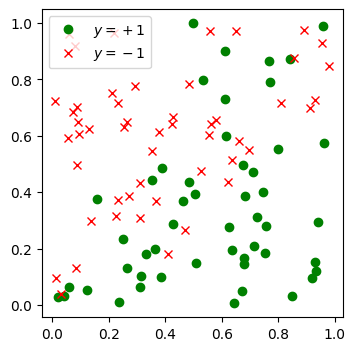

In [2]:
def plot(ax, x, y):
    is_positive = y.eq(1)
    plt.plot(x[is_positive, 0].numpy(), x[is_positive, 1].numpy(), 'go', label=r'$y = +1$')
    plt.plot(x[~is_positive, 0].numpy(), x[~is_positive, 1].numpy(), 'rx', label=r'$y = -1$')

    ax.set_aspect('equal', 'box')
    ax.legend()

figure, ax = plt.subplots(1, 1, figsize=(4, 4))
plot(ax, train_x, train_y)
plt.show()

## Inference
We define the probit model, which runs elliptical slice sampling to draw samples from the posterior \\(p(\mathbf{w} \mid \mathbf{y})\\).

In [3]:
from functools import cached_property
from linear_ess import EllipticalSliceSampler


class ProbitModel:
    def __init__(self, train_x, train_y):
        n, d = train_x.size()
        self.d = d
        
        # The elliptical slice sampler works for standard multivariate normal distributions truncated by A @ x <= b
        self.sampler = EllipticalSliceSampler(
            A=-torch.cat([train_x * train_y.unsqueeze(-1), torch.eye(n)], dim=-1),
            b=torch.zeros(n),
            burnin=10000,
        )

    @cached_property
    def posterior_samples(self):
        """
        Returns:
            A tensor of size (num_samples, d), where num_samples == num_steps / thinning.
        """
        samples = self.sampler.launch(
            num_steps=1000, thinning=10,
        )

        # Throw away the last n dimensions corresponding to u
        return samples[:, :self.d]

    def predict(self, test_x):
        probabilities = torch.distributions.Normal(0., 1.).cdf(
            test_x @ self.posterior_samples.T
        )

        return probabilities.mean(dim=-1).mul(2.).sub(1.).sign()

In [4]:
model = ProbitModel(train_x, train_y)

In [5]:
prediction = model.predict(test_x)

print("probit model test accuracy {:f}".format(prediction.eq(test_y).float().mean().item()))
print("ground truth model test accuracy {:f}".format(torch.sign(test_x @ w).eq(test_y).float().mean().item()))

probit model test accuracy 0.840000
ground truth model test accuracy 0.850000


## Visualize the Posterior Samples
Each posterior sample from \\(p(\mathbf{w} \mid \mathbf{y})\\) defines a linear classification model.
We visualize them in the plot below.

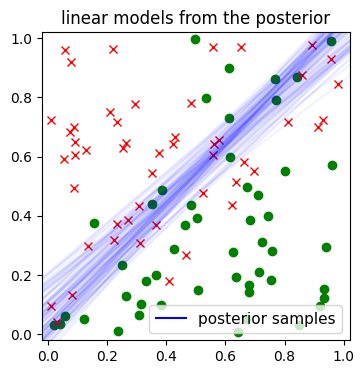

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

weights = model.posterior_samples
num_samples = weights.size(-2)

xs = torch.linspace(-0.02, 1.02, steps=123)

# The decision boundary is w1 * x1 + w2 * x2 + w3 = 0
# Write x2 as a function of x1
ys = -1.0 * (weights[:, 0].unsqueeze(-1) * xs.unsqueeze(-2) + weights[:, 2].unsqueeze(-1)) / weights[:, 1].unsqueeze(-1)

figure, ax = plt.subplots(figsize=(4, 4))

plot(ax, train_x, train_y)

for i in range(num_samples):
    ax.plot(xs.numpy(), ys[i].numpy(), 'b-', alpha=0.05)

lines = mlines.Line2D([], [], color='b', label='posterior samples')
ax.legend(handles=[lines], fontsize=11)
ax.set_ylim(-0.02, 1.02)
ax.set_xlim(-0.02, 1.02)
ax.set_title("linear models from the posterior")

plt.show()